In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
import torchvision
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
import time

Using TensorFlow backend.


In [ ]:
!unzip l2_cnn_liran.zip

In [ ]:
def labelMoreThenOne(data,label):
    return len(list(filter(lambda item : item[1] == label ,data))) > 1

In [ ]:
def createImagesDataset(root_path):
  size = 28
  image_folder = torchvision.datasets.ImageFolder(root_path,transform=transforms.Compose([transforms.Resize((size,size)) ]))       
  dataset = list(filter(lambda item :labelMoreThenOne(image_folder,item[1]),image_folder))  
  num_examples = len(dataset)
  data = np.zeros(shape=(num_examples,size,size))
  labels = np.zeros(num_examples)
  for index,(img , label) in enumerate(dataset):
    arr = np.array(img)
    data[index,:,:] = arr[:,:,0]
    labels[index] = label

  return data,labels

In [ ]:
path_root_train = "./train"

images,labels = createImagesDataset(path_root_train)
print(labels)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21. 22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 23. 23. 23. 23.
 23. 23. 23. 23. 23. 23. 24. 24. 24. 24. 24. 24. 24

In [ ]:
print(images.shape)
print(labels.shape)

(400, 28, 28)
(400,)


In [ ]:
epochs = 300


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  

def create_pairs(x, images_indices,setClasses):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(images_indices[index]) for index,d in enumerate(setClasses)]) - 1
    print("n ", n)
    print("images_indices ", images_indices)
    print("setClasses ", len(setClasses))
    for index,c in enumerate(setClasses):
        for i in range(n):
            z1, z2 = images_indices[index][i], images_indices[index][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, len(setClasses))
            dn = (index + inc) % len(setClasses) - 1
            z1, z2 = images_indices[index][i], images_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
print(images.shape)
x_train, x_test, y_train, y_test  = train_test_split(images,labels,train_size =0.6,test_size=0.4)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print("input_shape: ", input_shape)

# create training+test positive and negative pairs
images_indices = [np.where(y_train == i)[0] for i in list(set(y_train))]
tr_pairs, tr_y = create_pairs(x_train, images_indices,list(set(y_train)))

images_indices = [np.where(y_test == i)[0] for i in list(set(y_test))]
te_pairs, te_y = create_pairs(x_test, images_indices,list(set(y_test)))

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
model.save('Keras_cnn_model'+str(time.time()))

(400, 28, 28)
input_shape:  (28, 28)
n  3
images_indices  [array([ 12,  15,  48,  75, 129, 235]), array([ 11,  38,  76,  80, 104, 156]), array([ 13, 105, 107, 115, 136, 186]), array([ 52,  78, 135, 144, 201, 216]), array([ 33,  37,  79, 169, 195, 203, 206, 232]), array([ 20,  22,  42,  54, 126, 134, 159, 219]), array([ 69, 100, 193, 202, 214, 215, 229]), array([  3,  14,  55,  86, 120]), array([102, 146, 154, 190, 222]), array([ 23,  26,  53, 198, 217]), array([ 27,  93, 108, 122, 132, 194, 227]), array([  9,  94, 131, 141, 208]), array([ 19,  30,  56, 113, 130, 167, 236]), array([ 21,  44,  50, 103, 153, 175, 180, 223]), array([ 10,  25,  49,  96, 145, 211]), array([ 51,  60, 118, 119, 164, 183]), array([ 32,  83, 121, 138, 165, 171]), array([  0,  84,  87, 139, 221]), array([ 18, 106, 114, 124, 160, 197, 205, 234]), array([  4,   8,  66, 147, 176, 191]), array([ 24,  29,  72,  77, 157, 163, 177]), array([ 95, 117, 137, 150, 188]), array([ 40,  62, 123, 142, 178, 199, 239]), array([  

(320, 28, 28)


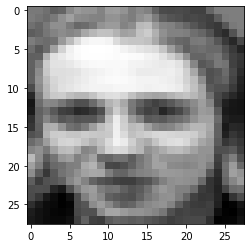

In [ ]:
from matplotlib import pyplot as plt

# the data, split between train and test sets
print(images.shape)
x_train, x_test, y_train, y_test  = train_test_split(images,labels,train_size =0.6,test_size=0.4)

plt.imshow(x_train[0],cmap="gray")


In [ ]:
from PIL import Image

print(type(x_train[0]))
display(keras.preprocessing.image.array_to_img(x_train[0][]))



<class 'numpy.ndarray'>


ValueError: ignored

In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [ ]:
import eli5

In [ ]:
from tensorflow import keras

In [ ]:
print(type(y_pred), y_pred.shape)

<class 'numpy.ndarray'> (64, 1)


In [ ]:
# my_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
# print(type(te_pairs[:, 0]), te_pairs[:, 0].shape)
print(type(te_pairs[0][0]), te_pairs[0][0].shape)

<class 'numpy.ndarray'> (28, 28)
